In [6]:
import os, sys
sys.path.insert(0, '/home/jtorrenc/mvesc/ETL')
sys.path.insert(0, '/home/jtorrenc/mvesc/ModelsResults')
sys.path.insert(0, '/home/jtorrenc/mvesc/Features')

from mvesc_utility_functions import *
from estimate_prediction_model import build_outcomes_plus_features,temporal_cohort_test_split,impute_missing_values
import numpy as np
import pandas as pd
import random
from functools import partial
import itertools
from my_timer import Timer 
import pickle
import yaml
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def student_list(filename):
    model_name = filename.split('_')[-3]
    with open('/mnt/data/mvesc/Models_Results/pkls/'+filename+'_'+ model_name + '.pkl', "rb" ) as f:
        d = pickle.load(f)
    train = d['train_y'].index
    val = d['val_y'].index
    test = d['test_y'].index
    return train, val, test

In [8]:
def scale_features(train, val, test, strategy):
    """                                                                         
    Scales features based on the training values with the given strategy   
    Modified here to also return the scaler
                                                                                
    :param pd.DataFrame train:                                                  
    :param pd.DataFrame val:                                                    
    :param pd.DataFrame test:                                                   
    :param str strategy:                                                        
    :returns: scaled training, val, and test sets, and scaler                            
    :rtype: pd.DataFrame, pd.DataFrame, pd.DataFrame, sklearn scaler object                    
    """
    zero_variance_columns = [x for x in train.columns if len(train[x].unique()) == 1]
    train.drop(zero_variance_columns, axis=1, inplace=True)
    val.drop(zero_variance_columns, axis=1, inplace=True)
    test.drop(zero_variance_columns, axis=1, inplace=True)

    if (strategy == 'none'):
        return train, val, test

    elif(strategy == 'standard' or strategy == 'robust'):
        non_binary_columns = [x for x in train.columns if  len(train[x].unique())>2]
        if (len(non_binary_columns) > 0):
            scaler = StandardScaler() if strategy == 'standard' \
                     else RobustScaler()
            train_non_binary = train[non_binary_columns]
            val_non_binary = val[non_binary_columns]
            test_non_binary = test[non_binary_columns]
            scaler.fit(train_non_binary)
            train_non_binary = pd.DataFrame(scaler.transform(train_non_binary),
                columns = non_binary_columns, index = train.index)
            val_non_binary = pd.DataFrame(scaler.transform(val_non_binary),
                columns = non_binary_columns, index = val.index)
            test_non_binary = pd.DataFrame(scaler.transform(test_non_binary),
                columns = non_binary_columns, index = test.index)
            train_scaled = train.drop(non_binary_columns, axis=1)
            val_scaled = val.drop(non_binary_columns, axis=1)
            test_scaled = test.drop(non_binary_columns, axis=1)
            train_scaled = train_scaled.merge(train_non_binary,
                left_index=True, right_index=True)
            val_scaled = val_scaled.merge(val_non_binary,
                left_index=True, right_index=True)
            test_scaled = test_scaled.merge(test_non_binary,
                left_index=True, right_index=True)
            return train_scaled,val_scaled, test_scaled, scaler
        else:
            return train, val, test, scaler

    else:
        print('unknown feature scaling strategy. try "{}", "{}", or "{}"'\
              .format('standard', 'robust', 'none'))
        return train, val, test

In [9]:
def read_and_preprocess(filename):
    """
    Reads in a pickeled model file and rebuilds the training, test, and validation data.
    Returns features for all the students, both scaled and unscaled, the scaler, the column-order, and the model itself.
    
    :param str filename: the filename specifying which model to read in
    :returns: scaled features, unscaled features, sklearn scaler, list of columns in order, the model
    :rtype: pd.DataFrame, pd.DataFrame, sklearn scaler object, list of str, sklearn estimator object
    """
    model_name = filename.split('_')[-3]
    with open('/mnt/data/mvesc/Models_Results/pkls/'+filename+'_'+ model_name + '.pkl', "rb" ) as f:
        d = pickle.load(f)
    model_options = d['model_options']
    model = d['estimator']
    columns = d['estimator_features']
    outcome_plus_features = build_outcomes_plus_features(model_options,None)
    outcome_plus_features.dropna(subset=[model_options['outcome_name'],
            model_options['cohort_grade_level_begin']], inplace=True)
    train, val, test = temporal_cohort_test_split(outcome_plus_features,
            model_options['cohort_grade_level_begin'],
            model_options['cohorts_test'],
            model_options['cohorts_val'],
            model_options['cohorts_training'])
    train_X_pre = train.drop([model_options['outcome_name'],
                      model_options['cohort_grade_level_begin']],axis=1)
    test_X_pre = test.drop([model_options['outcome_name'],
                        model_options['cohort_grade_level_begin']],axis=1)
    val_X_pre = val.drop([model_options['outcome_name'],
                      model_options['cohort_grade_level_begin']],axis=1)
    train_y = train[model_options['outcome_name']]
    test_y = test[model_options['outcome_name']]
    val_y = val[model_options['outcome_name']]
    train_X, val_X, test_X = impute_missing_values(train_X_pre, val_X_pre, test_X_pre,\
    model_options['missing_impute_strategy'])
    train_X = train_X.filter(columns)
    val_X = val_X.filter(columns)
    test_X = test_X.filter(columns)
    train_X, val_X, test_X, scaler = scale_features(train_X, val_X, test_X,
                                                    model_options['feature_scaling'])
    X = pd.concat([train_X,val_X,test_X])
    X_pre = pd.concat([train_X_pre,val_X_pre,test_X_pre])

    return X, X_pre, scaler, columns, model

In [10]:
def split_columns(X, columns):
    """
    Splits the list of feature names into binary features and continuous features
    
    :param pd.DataFrame X: feature values for students
    :param list columns: list of strings indicating the desirred order for column names - read in from pickle
    :returns: list of continuous column names, list of binary column names
    :rtypes: list, list
    """
    binary_features = pd.DataFrame(~X.apply(lambda x: len(x.unique()),axis=0).gt(2), columns = ['binary'])
    cts_columns = [c for c in columns if not binary_features['binary'].loc[c]]
    binary_columns = [c for c in columns if binary_features['binary'].loc[c]]
    return cts_columns, binary_columns

In [11]:
def categorical_feature_dict(all_features_path, binary_columns):
    """
    Generates a dictionary maping binary columns to their appropriate categorical base feature name
    
    :param str all_features_path: path from current directory to all_features.yaml in the Features folder
    :param list binary_columns: list of column names for binary features
    :returns: dictionary maping binary columns to their appropriate categorical base feature name
    :rtypes: dict
    """
    with open(all_features_path, 'r') as f:
            all_features = yaml.load(f)
    feature_base = itertools.chain.from_iterable([a  for a in all_features.values()])
    feature_base = [y[:-1] if '*' in y else y for y in feature_base]
    binary_base = set()
    for f in feature_base:
        for b in binary_columns:
            if f in b and 'null' not in b:
                base = []
                flag=False
                if 'gr' in b:
                    for a in b.split('_'):
                        if flag:
                            base.append(a)
                            break
                        base.append(a)
                        if a=='gr':
                            flag=True
                    binary_base.add('_'.join(base))
                else:
                    binary_base.add(f)
    binary_base = list(binary_base)
    binary_dict = {}
    for b in binary_base:
        binary_dict[b] = [f for f in binary_columns if b == f[:len(b)]]
    return binary_dict

In [79]:
def plot_binary_features(model, student, binary_dict, train_X, plot=True, save=False):
    X_student = train_X.loc[student]
    I = pd.DataFrame(columns = ['delta','direction', 'current_val','var_type', 'was_null'], index=binary_dict.keys())
    base_list = []
    for base, features in binary_dict.items():
        base_list.append(base)
        if len(features)>1: # for categorical
            X = pd.DataFrame(np.tile(X_student,[len(features),1]).transpose(),index=X_student.index) # reset X matrix
            current_val = 'other'
            for i,f in enumerate(features):
                if train_X[f].loc[student]:
                    current_val = f[len(base)+1:]
                for g in features:
                    X[i].loc[g] = 1 if g == f else 0
            if current_val == 'other': # for dropped features
                X[i+1] = X[i]
                for g in features:
                    X[i+1].loc[g] = 0
                current_val_ind = len(features)
                features.append(current_val)
            else:
                current_val_ind = [i for i,f in enumerate(features) if current_val in f][0]
            prob = [a[1] for a in model.predict_proba(X.transpose())]
            I['delta'].loc[base] = abs(np.mean([p - prob[current_val_ind] 
                                                 for i, p in enumerate(prob)
                                                if i != current_val_ind ]))
            I['direction'].loc[base] = 'protective' if prob[current_val_ind] < np.mean(prob) else 'risky'
            I['current_val'].loc[base] = current_val
            I['var_type'].loc[base] = 'categorical'
            I['was_null'].loc[base] = np.bool('null' in current_val)
            if plot: # TODO: order by probability
                fig, ax = plt.subplots()
                plt.scatter( np.arange(len(features)), prob);
                plt.scatter( current_val_ind , prob[current_val_ind], label=current_val, color = 'red');
                ax.set_xticks( np.arange(len(features)))
                ax.set_xticklabels( [f[len(base)+1:] for f in features], rotation=90 ) ;
                plt.ylim([0,1])
                plt.title('student {}'.format(student));
                plt.xlabel('{} value'.format(base))
                plt.ylabel('risk score')
                if save:
                    plt.savefig('../Error_Feature_Analysis/RF_feature_plots/student_{0}_{1}'.format(student,base),
                        bbox_inches='tight')
        else: # for truly binary features
            f= features[0]
            X = pd.DataFrame(np.tile(X_student,[2,1]).transpose(),index=X_student.index) # reset X matrix
            current_val = train_X[f].loc[student]
            X[0].loc[f] = 0 
            X[1].loc[f] = 1 
            prob = [a[1] for a in model.predict_proba(X.transpose())]
            diff = prob[int(current_val)] -  prob[int(not  bool(current_val))]
            I['delta'].loc[base] = abs(diff)
            I['current_val'].loc[base] = current_val
            I['var_type'].loc[base] = 'binary'
            I['was_null'].loc[base] = np.isnan(current_val) 
            if diff > 0:
                I['direction'].loc[base] = 'protective'   
            else:
                I['direction'].loc[base] = 'risky' 
            if plot:
                fig, ax = plt.subplots()
                plt.scatter( [0,1], prob);
                plt.scatter( current_val , prob[int(current_val)], label=current_val, color = 'red');
                ax.set_xticks([0,1] )
                ax.set_xticklabels( ['False', 'True'], rotation=90 ) ;
                plt.ylim([0,1])
                plt.title('student {}'.format(student));
                plt.xlabel('{} value'.format(base))
                plt.ylabel('risk score')
                if save:
                    plt.savefig('../Error_Feature_Analysis/RF_feature_plots/student_{0}_{1}'.format(student,base),
                        bbox_inches='tight')
    return I

In [127]:
def binary_feature_importance(model, student, binary_dict, train_X):
    X_student = train_X.loc[student]
    I = pd.DataFrame(columns = ['delta','direction', 'current_val','var_type', 'was_null'], index=binary_dict.keys())
    for base, features in binary_dict.items():
        X = pd.DataFrame(np.tile(X_student,[len(features),1]).transpose(),index=X_student.index) 
        if len(features)>1: # for categorical
            # if none of the corresponding binary values are one, 
            # then this student's category was one that didn't appear in training data
            current_val = 'other' 
            for i,f in enumerate(features):
                if train_X[f].loc[student]:
                    current_val = f[len(base)+1:]
                for g in features:
                    X[i].loc[g] = 1 if g == f else 0
            if current_val == 'other':
                X[i+1] = X[i]
                for g in features:
                    X[i+1].loc[g] = 0
                current_val_ind = len(features)
            else:
                current_val_ind = [i for i,f in enumerate(features) if current_val in f][0]
            prob = [a[1] for a in model.predict_proba(X.transpose())]
            I['delta'].loc[base] = abs(np.mean([p - prob[current_val_ind] 
                                                 for i, p in enumerate(prob)
                                                if i != current_val_ind ]))
            # protective if current risk is less than mean of all possible options
            I['direction'].loc[base] = 'protective' if prob[current_val_ind] < np.mean(prob) else 'risky'
            I['current_val'].loc[base] = current_val
            I['var_type'].loc[base] = 'categorical'
            I['was_null'].loc[base] = np.bool('null' in current_val)
        else: # for truly binary features
            f= features[0]
            X = pd.DataFrame(np.tile(X_student,[2,1]).transpose(),index=X_student.index) # reset X matrix
            current_val = train_X[f].loc[student]
            X[0].loc[f] = 0 
            X[1].loc[f] = 1 
            prob = [a[1] for a in model.predict_proba(X.transpose())]
            diff = prob[int(current_val)] -  prob[int(not  bool(current_val))]
            I['delta'].loc[base] = abs(diff)
            I['current_val'].loc[base] = current_val
            I['var_type'].loc[base] = 'binary'
            I['was_null'].loc[base] = np.isnan(current_val) 
            if diff > 0:
                I['direction'].loc[base] = 'risky' # switching would lower risk
            else:
                I['direction'].loc[base] = 'protective' 
    return I

In [85]:
def plot_cts_features(model, student, cts_columns, train_X_pre, train_X, scaler, save):
    X_student = train_X.loc[student]
    n_steps = 100
    for feature in cts_columns:
        current_val = train_X_pre[feature].loc[student]
        if not np.isnan(current_val): # skip null values
            X = pd.DataFrame(np.tile(X_student,[n_steps,1]).transpose(),index=X_student.index) # reset X matrix
            values = np.linspace(min(train_X[feature]), max(train_X[feature]), n_steps)
            for i,v in enumerate(values):
                X[i].loc[feature] = v
            prob = [a[1] for a in model.predict_proba(X.transpose())]
            values_pre = pd.DataFrame(scaler.inverse_transform(X.loc[cts_columns].transpose()).transpose(),
                                index = cts_columns,
                                columns = X.columns)
            values_pre = values_pre.loc[feature]
            plt.figure()
            plt.hold='on'
            plt.vlines(current_val,0,1,label=str(current_val))
            plt.plot(values_pre, prob);
            plt.ylim([0,1])
            plt.xlim([min(values_pre)-.1,max(values_pre)+.1])
            plt.title('student {}'.format(student));
            plt.xlabel('{} value'.format(feature))
            plt.ylabel('risk score')
            if save:
                plt.savefig('../Error_Feature_Analysis/RF_feature_plots/student_{0}_{1}'.format(student,feature),
                        bbox_inches='tight')
                if feature == 'math_normalized_gr_8':
                    current_prob =  model.predict_proba(X_student)[0][1]
                    return values_pre, prob, current_val, current_prob

In [161]:
def cts_feature_importance(model, students, cts_columns, train_X_pre, train_X, scaler, shift):
    train_std = train_X.std(axis=0)
    n_features = len(cts_columns)
    n_students = len(students)
    X = pd.DataFrame(columns = range(3*n_features*n_students),
                     index=train_X.columns)
    I_list = []
    for s_ind, s in enumerate(students):
        X_student = train_X.loc[s]
        X[X.columns[(s_ind*3*n_features):(s_ind*3*n_features+3*n_features)]] = \
        np.tile(X_student,[3*n_features,1]).transpose()
        for f_ind, feature in enumerate(cts_columns):
            current_ind = s_ind*n_features*3+f_ind*3 # three steps per student/feature
            s = shift*train_std[feature]
            X[current_ind].loc[feature] = X[current_ind+1].loc[feature] - s
            X[current_ind+2].loc[feature] = X[current_ind+1].loc[feature] + s
    results = model.predict_proba(X.transpose())
    prob = pd.Series([a[1] for a in results])
    down = prob.diff().abs().iloc[1::3] # difference in probability when feature is pushed down
    up = prob.diff().abs().iloc[2::3] # difference in probability when feature is pushed up
    for s_ind, s in enumerate(students):
        I = pd.DataFrame(columns = ['delta', 'direction', 'current_val','var_type','was_null'],index=cts_columns)
        for f_ind, feature in enumerate(cts_columns):
            current_ind = s_ind*n_features+f_ind # one step per student/feature
            I['delta'].loc[feature] = max(up.iloc[current_ind], down.iloc[current_ind])
            prob_current = prob.iloc[current_ind*3+1]
            if down.iloc[current_ind] > up.iloc[current_ind]:
                prob_shift = prob.iloc[current_ind*3]  
            else: 
                prob_shift = prob.iloc[current_ind*3+2]
            if prob_current < prob_shift:
                I['direction'].loc[feature] = 'protective' # feature is lessening to student's risk
            else:
                I['direction'].loc[feature] = 'risky' # feature is raising student's risk
            I['current_val'].loc[feature] = X[current_ind*3+1].loc[feature]
            I['was_null'].loc[feature] = np.isnan(train_X_pre[feature].loc[student])
        I['var_type'] = 'continuous'
        I_list.append(I)
    return I_list

In [116]:
def plot_features(model_filename, student, all_features_path, save): 
    X, X_pre, scaler, column_order, model = read_and_preprocess(filename)
    cts_columns, binary_columns = split_columns(X, column_order)
    binary_dict = categorical_feature_dict(all_features_path, binary_columns)
    x,y,current, current_prob = plot_cts_features(model, student, cts_columns, X_pre, X, scaler, save=save)
    print(current, current_prob)
    plot_binary_features(model, student, binary_dict, X, True, save=save)
    return x,y,current, current_prob

In [165]:
def get_feature_importances(model_filename, students, all_features_path, shift):
    X, X_pre, scaler, column_order, model = read_and_preprocess(filename)
    cts_columns, binary_columns = split_columns(X, column_order)
    binary_dict = categorical_feature_dict(all_features_path, binary_columns)
    I_cts = cts_feature_importance(model, students, cts_columns, X_pre, X, scaler, shift)
    I_binary = []
    for student in students:
        temp = binary_feature_importance(model, student, binary_dict, X)
        I_binary.append(temp)
    I_all = [pd.concat([c,b]) for c,b in zip(I_cts, I_binary)]
    return I_all

In [89]:
all_features_path = '../Features/all_features.yaml'
filename = '08_17_2016_grade_10_param_set_16_RF_jg_139'
train_students, val_students, test_students = student_list(filename)

In [96]:
val_students
student = 6727

In [166]:
with Timer('feature importances'):
    students = val_students[:10]
    all_I = get_feature_importances(filename, val_students[:10], all_features_path, 1)
    for s in 

feature importances: 5.3e+01 seconds elapsed


In [215]:
all_I[0][np.logical_not(all_I[0]['was_null'])].sort_values('delta', ascending=False).head()

KeyError: 'was_null'

In [205]:
# TODO: make this so null features get something sensible for averaging/sorting
with Timer('joining'):
    I = pd.DataFrame(all_I[0]['delta'], index=all_I[0].index)
    for i, I_next in enumerate(all_I[1:]):
        I_temp = pd.DataFrame(I_next['delta'], index=I_next.index)
        I_temp.columns = [i]
        I = I.join(I_temp, how='outer')

joining: 0.02 seconds elapsed


In [213]:
pd.DataFrame(I.mean(axis=1), columns = ['mean_delta']).sort_values(by = 'mean_delta', ascending = False).head()

,mean_delta
atheletics_gr_9,0.060918
math_normalized_gr_8,0.052035
iss_gr_9,0.051823
math_normalized_gr_6,0.050563
discipline_incidents_gr_9,0.045922


/home/jgutman/env/lib/python3.4/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/jgutman/env/lib/python3.4/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


-1.04007074297 0.746857517702


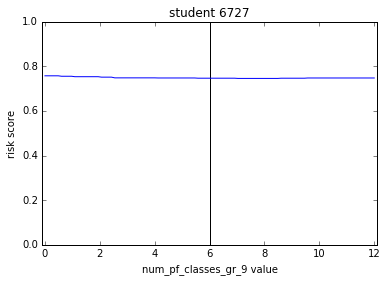

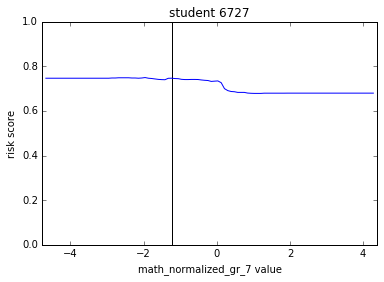

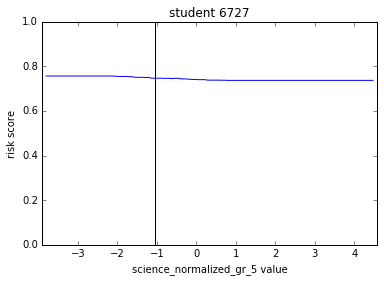

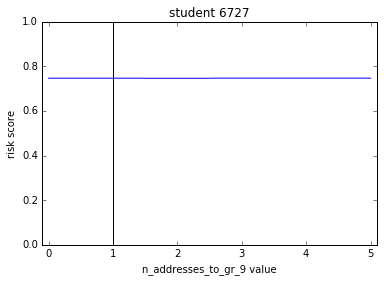

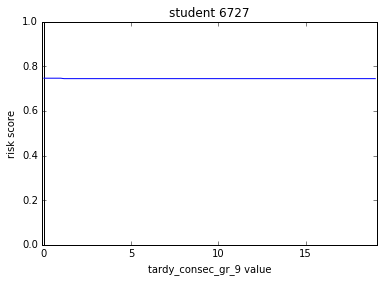

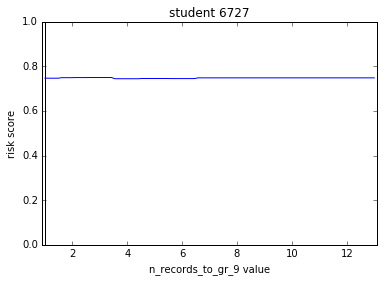

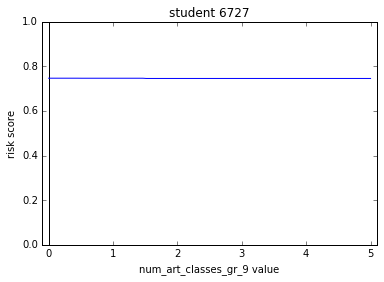

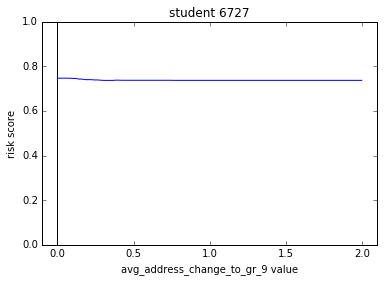

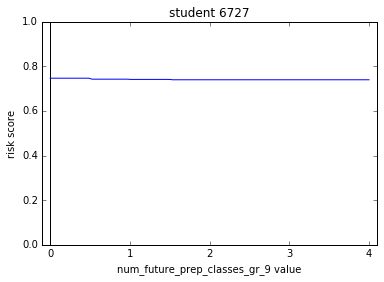

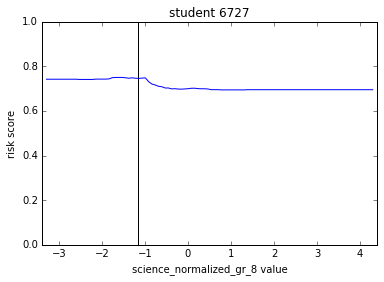

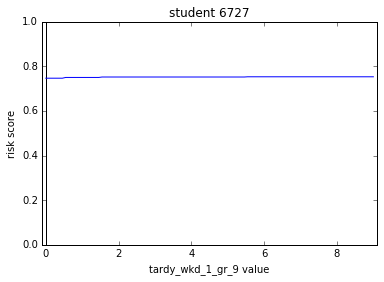

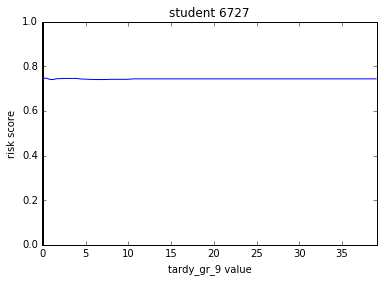

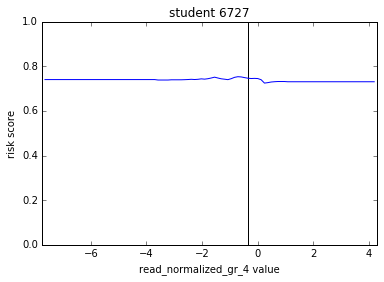

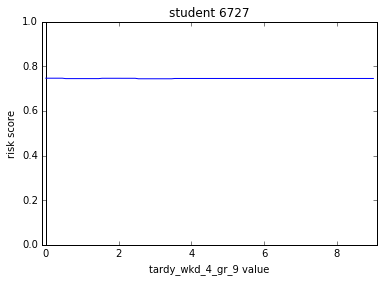

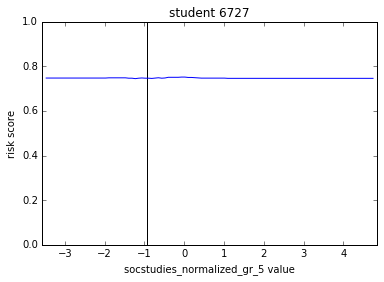

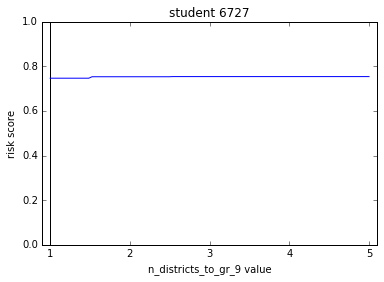

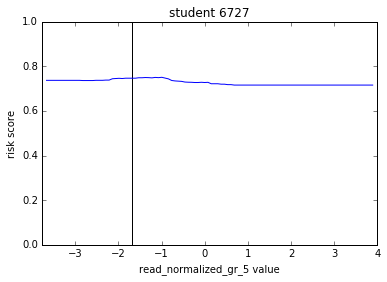

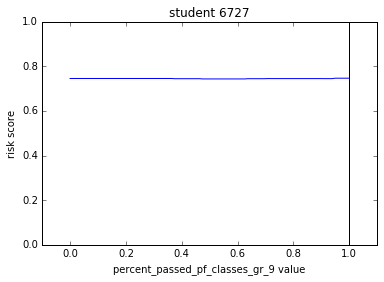

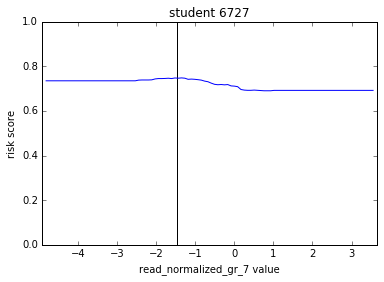

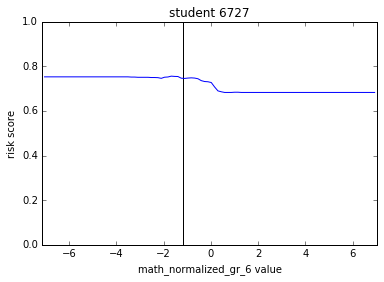

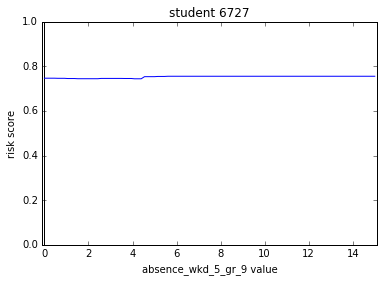

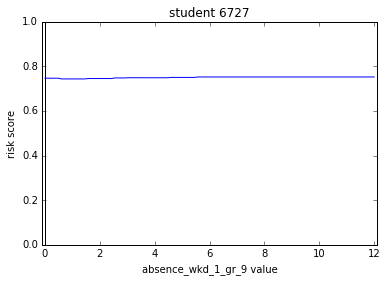

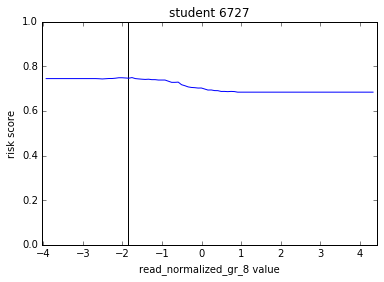

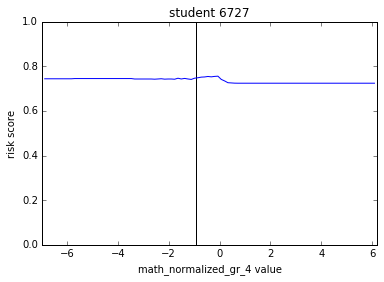

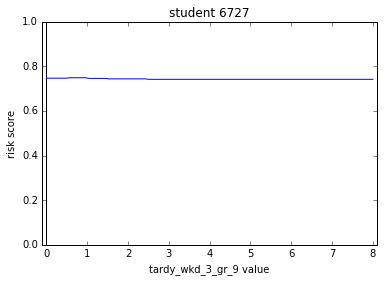

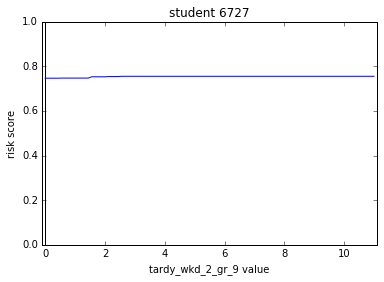

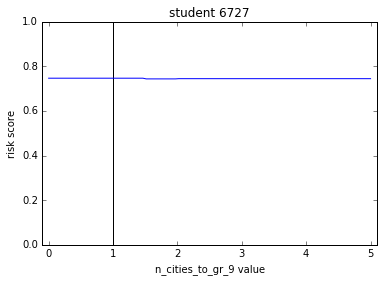

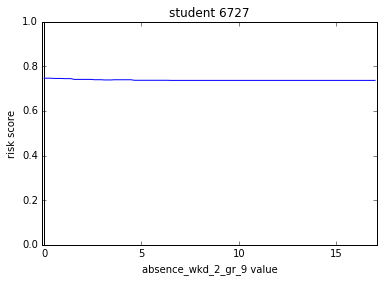

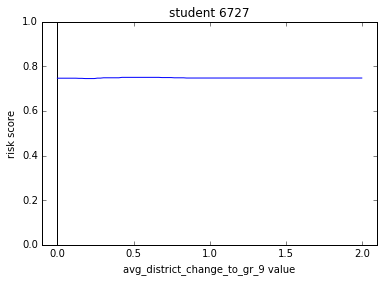

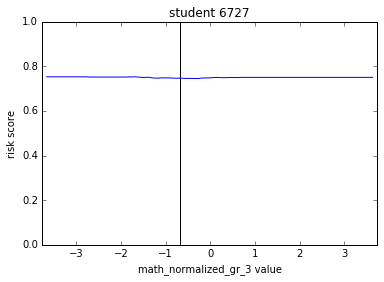

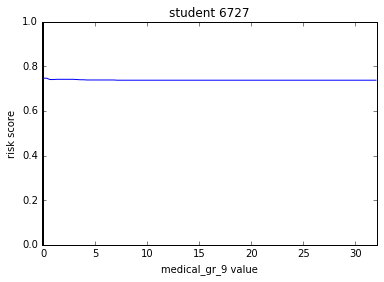

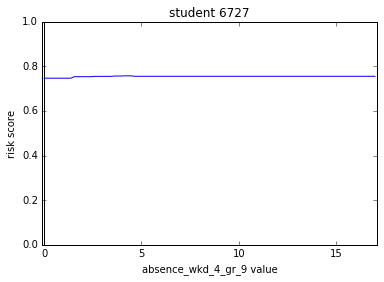

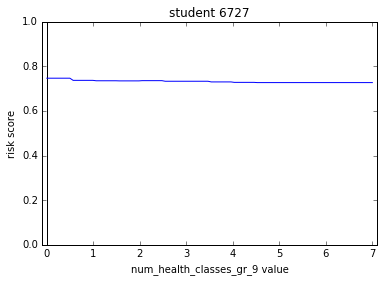

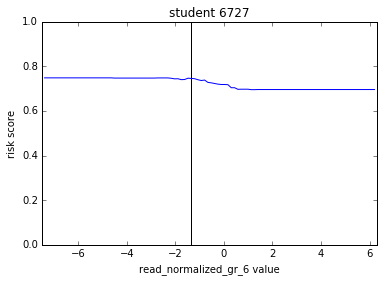

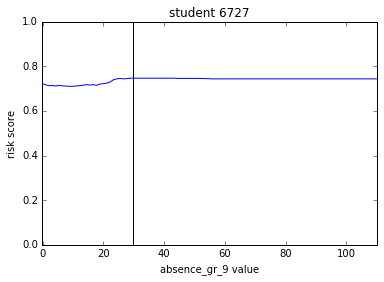

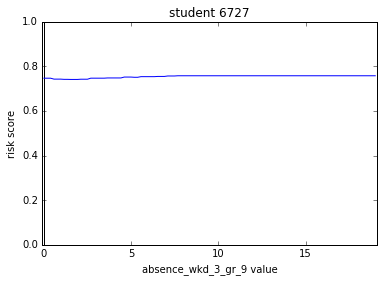

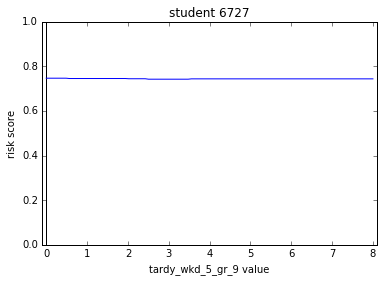

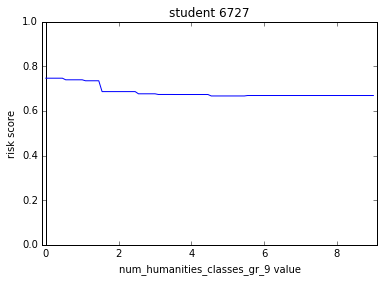

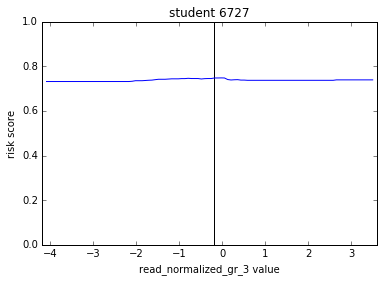

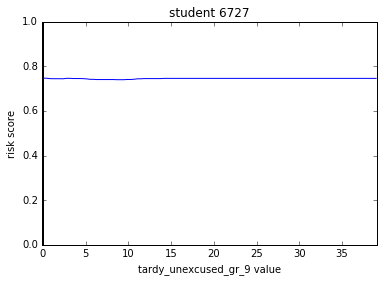

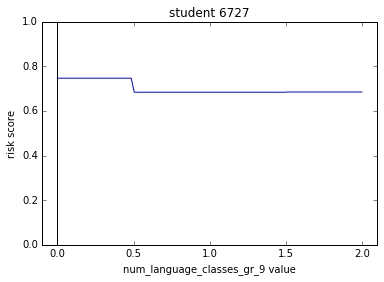

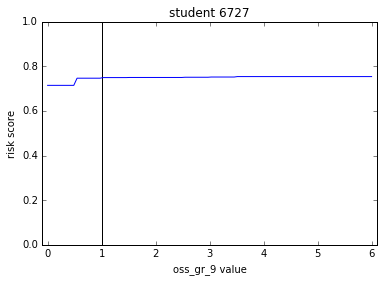

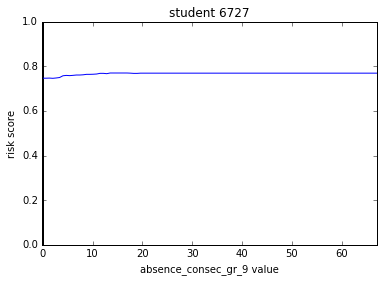

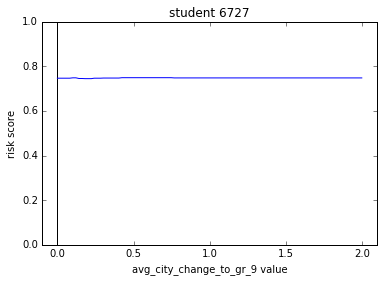

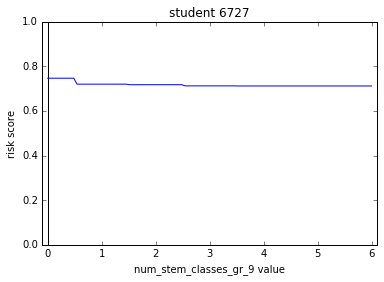

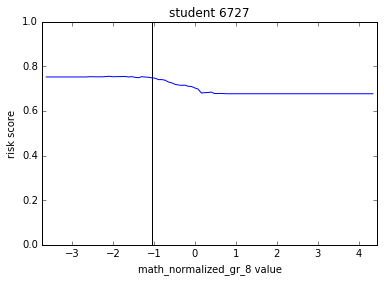

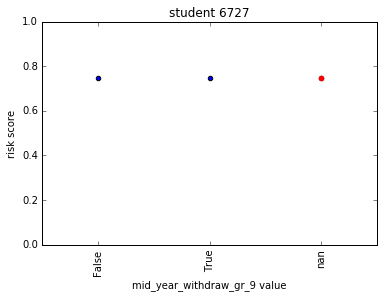

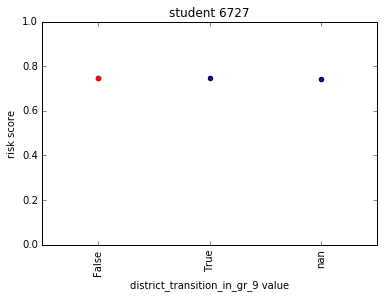

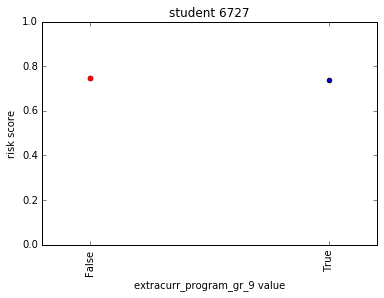

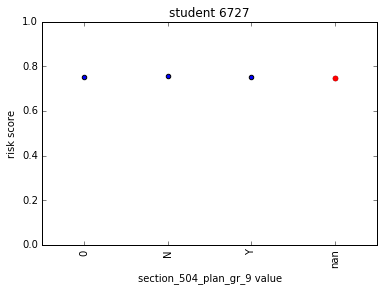

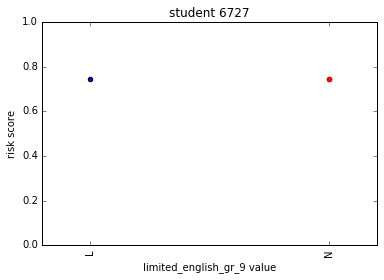

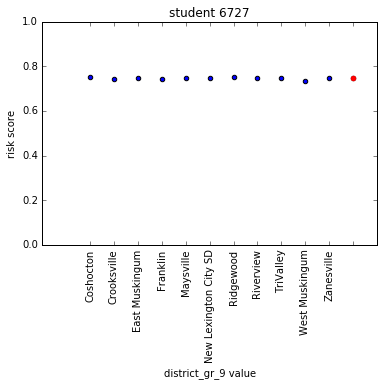

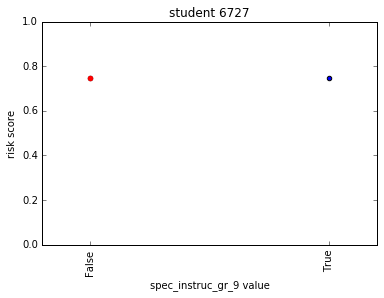

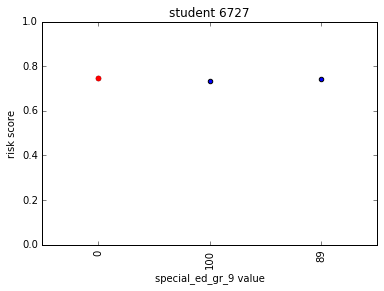

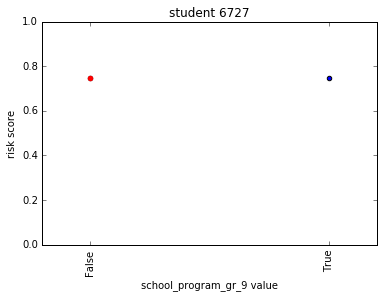

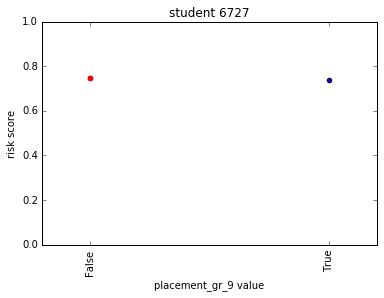

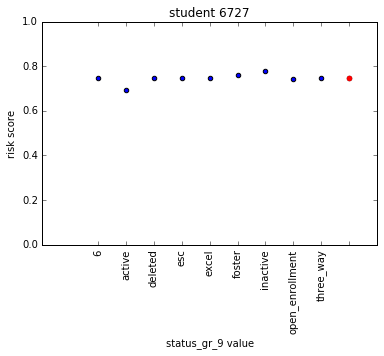

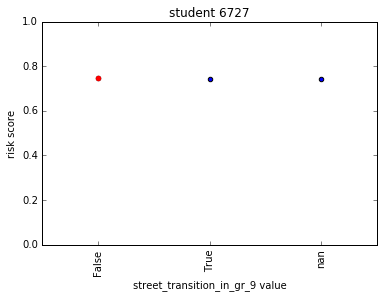

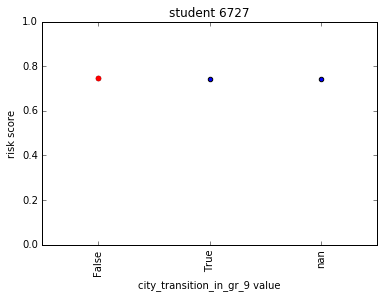

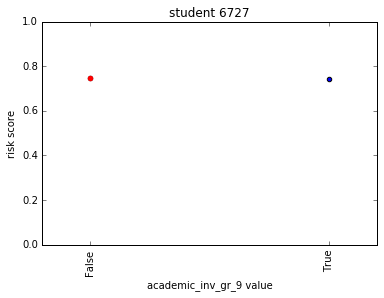

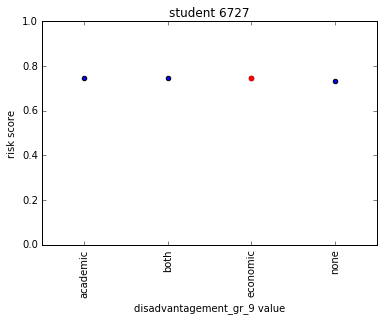

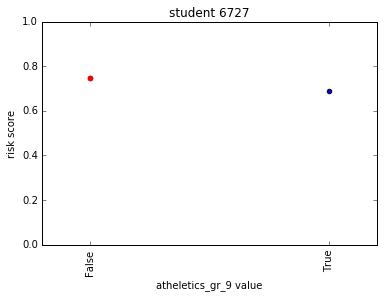

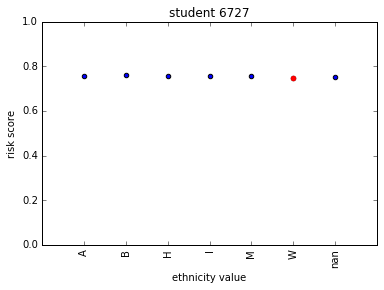

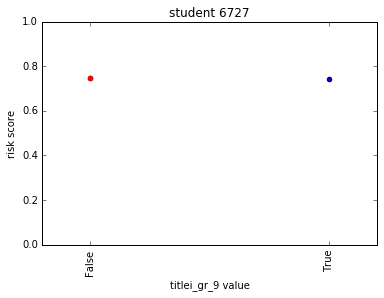

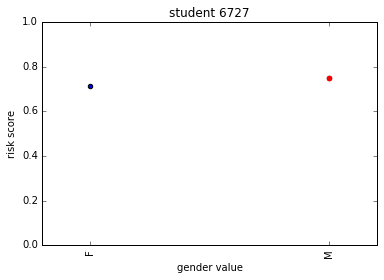

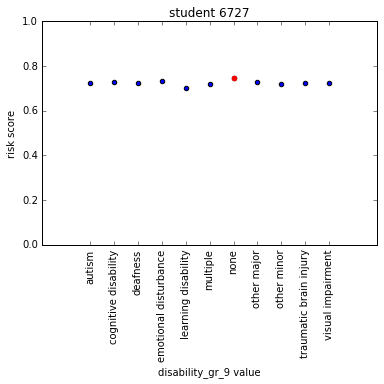

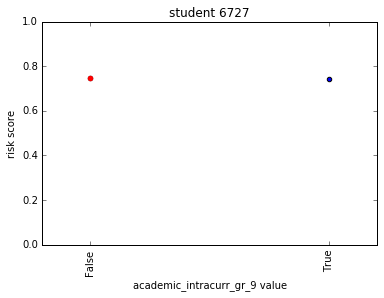

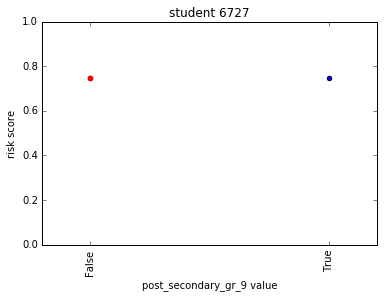

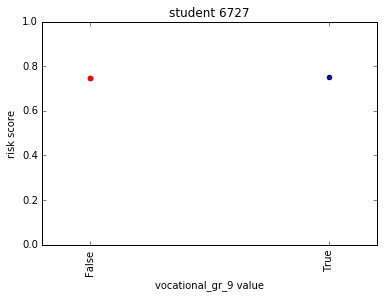

In [93]:
x, y, current, current_prob = plot_features(filena-me, student, all_features_path, True)

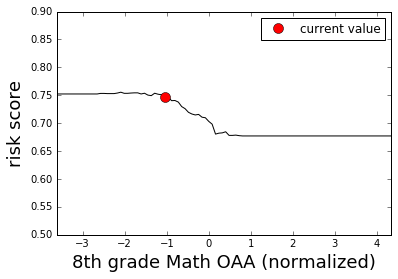

In [151]:
plt.figure()
plt.hold='on'
plt.plot(x, y, color='k');
plt.plot(current,current_prob,'or',label='current value', markersize=10)

plt.ylim([.5,.9])
plt.xlim([min(x),max(x)])
#plt.title('student {}'.format(student));
plt.legend(numpoints=1)
plt.xlabel('8th grade Math OAA (normalized)', size=18)
plt.ylabel('risk score',size=18)
plt.savefig('../Error_Feature_Analysis/RF_feature_plots/student_{0}_{1}_clean'.format(student,'math_normalized_gr_8'),bbox_inches='tight')